In [1]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [2]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

NameError: name 'bigquery_client' is not defined

In [3]:
test_df.drop_duplicates()

NameError: name 'test_df' is not defined

In [4]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [5]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install chardet\n!pip install db-dtypes\n!pip install catboost\n")

In [6]:
#Importing Libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import csv
import numpy as np

In [8]:
from google.cloud import bigquery
import scipy as sp
import statsmodels as sm
import statistics as stat
import sklearn
import patsy as pt
import chardet as ch
import click as cl
import cytoolz as cz
import dask
import decorator as dr
#import pyjson5 as py
import jsonschema as js
import tables
import db_dtypes
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
global df3

In [10]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [11]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [12]:
query_job1 = bigquery_client.query(query)
query_job1

QueryJob<project=ironhacks-data, location=US, id=ce0db95e-2316-4d0f-8ac7-a5940fdec357>

In [13]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [14]:
query_job2 = bigquery_client.query(query)
query_job2

QueryJob<project=ironhacks-data, location=US, id=d909191f-6004-4c1f-a79a-c14f5bd2c152>

In [15]:
!pip install db-dtypes
df1 = query_job2.to_dataframe()
df1.uu_id.nunique()

525

In [16]:
!pip install db-dtypes
df2 = query_job1.to_dataframe()
df2.uu_id.nunique()

525

In [17]:
df3 = pd.merge(df1,df2, on= ["uu_id","countyfips","tract","tract_name"])

In [18]:
#Expanding timeperiod to day, month and year
df3["time"] = pd.to_datetime(df3["timeperiod"], format= '%Y%m%d', errors = "coerce")
df3 =df3.drop("timeperiod", axis = 1)
df3["month"] = df3["time"].dt.month
df3["day"] = df3["time"].dt.day
str_col = ["tract_name", 'top_category_employer1', 'top_category_employer2',
       'top_category_employer3',"time"]
df3["uu_id_enc"] = df3["uu_id"].astype('category').cat.codes
#Encoding Strings
for col in str_col :
    df3[col] = df3[col].astype('category').cat.codes
int_col = list(set(df3.columns) -set(str_col)-set(["uu_id"]))
#dropping and replacing Nan, NaT   
df3 =df3.astype(str)
df3 = df3[df3["uu_id"] != np.nan]
df3 = df3.replace('NaT', np.nan)
df3 = df3.replace(str(np.nan),str(0))
#df3 = df3.dropna(subset = ["uu_id"], inplace=True)
for col in df3.columns:
    df3[col] = df3[col].str.replace(str("<NA>"),"0")
for col in int_col:
    df3[col] =df3[col].astype(float)
df = df3.copy()
df3.uu_id.nunique()

525

In [19]:
df3 = df.copy()
df3.columns

Index(['uu_id', 'week_number', 'countyfips', 'tract', 'tract_name',
       'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage',
       'time', 'month', 'day', 'uu_id_enc'],
      dtype='object')

In [20]:
races = ['race_black', 'race_other', 'race_white']
#for j in races:
g = (sum([df3[k] for k in races]))
df3["normalized_"+ str("races") ] = g
df3["normalized_"+ str("races") ].unique()

array([ 11.,   0.,  15.,  14.,  20.,  17.,  10.,  32.,  34.,  22.,  25.,
        46.,  60.,  29.,  42.,  16.,  12.,  21.,  39.,  13.,  57.,  55.,
        43.,  18.,  92.,  24.,  19.,  82.,  90., 142.,  47.,  33.,  75.,
       135.,  31.,  26.,  73.,  28., 109.,  37.,  23.,  27.,  30.,  38.,
        41.,  52.,  45.,  71.,  61.,  40.,  44.,  84.,  36.,  35.,  53.,
        89.,  70.,  64.,  63.,  59.,  49.,  68.,  51.,  76.,  58.,  65.,
        50.,  79.,  48.,  56.,  69.,  62.,  72.,  74.,  54.,  66.,  85.,
       105., 101., 140.,  83.,  87.,  96., 103.,  97.,  77., 138.,  67.,
        81.,  86., 117., 111.,  88.,  91., 128.,  93., 108., 155., 163.,
        99.,  78.,  80., 107., 100.,  95., 112., 110.,  94.])

In [21]:
ed = ['edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs']
for j in ed:
    df3["normalized_"+ str("education") ] = sum([df3[k] for k in ed])

In [22]:
gen = [ 'gender_female', 'gender_male']
for j in gen:
    df3["normalized_"+ str("gender") ] = sum([df3[k] for k in gen])

In [23]:
df3["sum"] = (df3["normalized_"+ str("education") ]+df3["normalized_"+ str("races") ]+df3["normalized_"+ str("gender") ])

In [24]:
def opt_features(x):
    df3["opt_var"]= (x[3]*df3["normalized_"+ str("education") ]**x[0]+x[4]*df3["normalized_"+ str("races") ]**x[1]+x[5]*df3["normalized_"+ str("gender") ]**x[2]+x[6])
    df4 =df3.corr()
    corr = -df4.loc["opt_var","total_claims"]
    return corr
import scipy   
op = scipy.optimize.minimize(opt_features, [1]*7,method="SLSQP") 
op

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_5936/3549868753.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 =df3.corr()


     fun: -0.9391144116847102
     jac: array([-4.72836196e-04, -2.24843621e-04,  1.12153590e-04, -2.12490559e-05,
       -8.30739737e-05,  3.21738422e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 229
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([1.03927724, 1.33562453, 1.35915665, 2.25884102, 0.35523893,
       0.23445896, 1.        ])

In [25]:
def opt_features2(x):
    #corr = -df4.loc["opt_var1","total_claims"]
    df3["opt_var2"]=x[0]*df3["opt_var"]+x[1]*df3["week_number"]
    df3["error"]= df3["total_claims"]-df3["opt_var2"]
    return abs(df3["error"]).sum()
cons = ({'type': 'ineq',
       'fun': lambda x:  opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  -opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  x[1]-1
       })
op2 = scipy.optimize.minimize(opt_features2, [1]*7,method="SLSQP", constraints = cons) 
op2

     fun: 813858.1207688724
     jac: array([812211.1171875, 337886.       ,      0.       ,      0.       ,
            0.       ,      0.       ,      0.       ])
 message: 'Positive directional derivative for linesearch'
    nfev: 8
     nit: 5
    njev: 1
  status: 8
 success: False
       x: array([1., 1., 1., 1., 1., 1., 1.])

In [26]:
df3["opt_var2"]=df3["opt_var"]+df3["opt_var2"]

In [27]:
df4 = df3.corr()
df4

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_5936/3822703957.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 = df3.corr()


,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
week_number,1.000000,-0.001015,-0.007765,-0.054817,0.019532,0.003564,-0.073129,0.003422,-0.006047,-0.033730,...,0.994291,0.025037,-0.006156,-0.048913,-0.054185,-0.039989,-0.052532,-0.048890,0.030031,-0.145223
countyfips,-0.001015,1.000000,0.014993,-0.011242,-0.002837,-0.003048,-0.005792,-0.019259,0.009003,-0.021396,...,-0.000952,0.000457,-0.015962,-0.024707,-0.015422,-0.025740,-0.024637,-0.024650,-0.024748,0.027384
tract,-0.007765,0.014993,1.000000,-0.041477,0.038854,-0.001890,-0.043448,-0.022050,0.005409,-0.020104,...,-0.007176,-0.007065,0.063204,-0.010364,-0.045897,-0.025235,-0.030135,-0.034986,-0.035626,0.033948
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939114,0.935487,-0.888089
edu_8th_or_less,0.019532,-0.002837,0.038854,0.069029,1.000000,-0.001538,0.013054,-0.006682,-0.002748,0.039022,...,0.020405,-0.008325,-0.011235,0.056605,0.006240,0.049529,0.042334,0.034968,0.036536,-0.029560
edu_grades_9_11,0.003564,-0.003048,-0.001890,0.267877,-0.001538,1.000000,0.063023,0.017355,-0.001633,0.205276,...,0.003867,-0.003019,-0.019018,0.198873,0.267673,0.206088,0.248195,0.266271,0.266751,-0.259220
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787297,0.782110,-0.762949
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541477,0.542151,-0.537039
edu_unknown,-0.006047,0.009003,0.005409,0.107267,-0.002748,-0.001633,0.011754,0.006395,1.000000,0.052286,...,-0.005783,-0.002308,0.004989,0.068465,0.012197,0.052776,0.049885,0.040827,0.040380,-0.022586
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.775079,0.772994,-0.759400


In [28]:
df4[abs(df4.total_claims)>0.5]
#df4.loc["ult","total_claims"]

,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939114,0.935487,-0.888089
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787297,0.782110,-0.762949
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541477,0.542151,-0.537039
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.775079,0.772994,-0.759400
gender_male,-0.038832,-0.025299,-0.025640,0.738217,0.050745,0.169898,0.582283,0.376703,0.043780,0.650736,...,-0.036812,-0.022545,-0.002551,0.606272,0.688769,0.912246,0.829481,0.783864,0.781382,-0.765767
race_black,-0.057827,0.010962,-0.015516,0.594516,0.012987,0.123855,0.470553,0.291321,0.051318,0.484824,...,-0.059313,0.018327,-0.003819,0.670411,0.546791,0.489177,0.626942,0.625488,0.621388,-0.604602
normalized_races,-0.048913,-0.024707,-0.010364,0.790695,0.056605,0.198873,0.594066,0.405391,0.068465,0.608157,...,-0.046182,-0.027418,-0.004696,1.000000,0.719309,0.668324,0.876010,0.844055,0.840822,-0.824220
normalized_education,-0.054185,-0.015422,-0.045897,0.897792,0.006240,0.267673,0.817667,0.578977,0.012197,0.676363,...,-0.051906,-0.022683,0.003102,0.719309,1.000000,0.751417,0.911358,0.956102,0.952537,-0.933356
normalized_gender,-0.039989,-0.025740,-0.025235,0.805103,0.049529,0.206088,0.627753,0.413722,0.052776,0.904675,...,-0.038459,-0.017745,-0.001875,0.668324,0.751417,1.000000,0.909304,0.858039,0.855521,-0.839424
sum,-0.052532,-0.024637,-0.030135,0.922510,0.042334,0.248195,0.752760,0.514986,0.049885,0.822653,...,-0.050152,-0.024817,-0.001318,0.876010,0.911358,0.909304,1.000000,0.983388,0.979974,-0.960823


In [29]:
features =df4[abs(df4.total_claims)>0.6].index
features

Index(['total_claims', 'edu_hs_grad_equiv', 'gender_female', 'gender_male',
       'normalized_races', 'normalized_education', 'normalized_gender', 'sum',
       'opt_var', 'opt_var2', 'error'],
      dtype='object')

total_claims (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


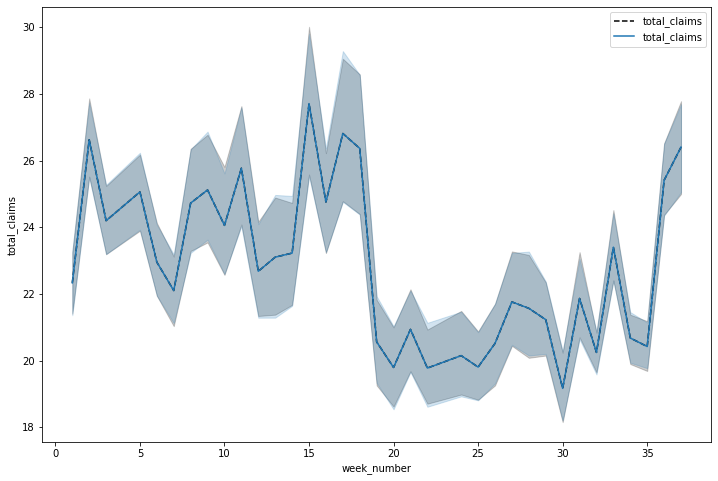

edu_hs_grad_equiv (1.0, 0.4980392156862745, 0.054901960784313725)


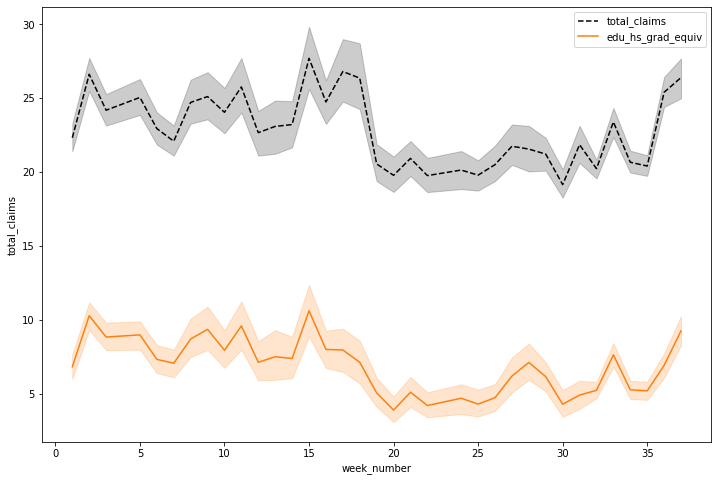

gender_female (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)


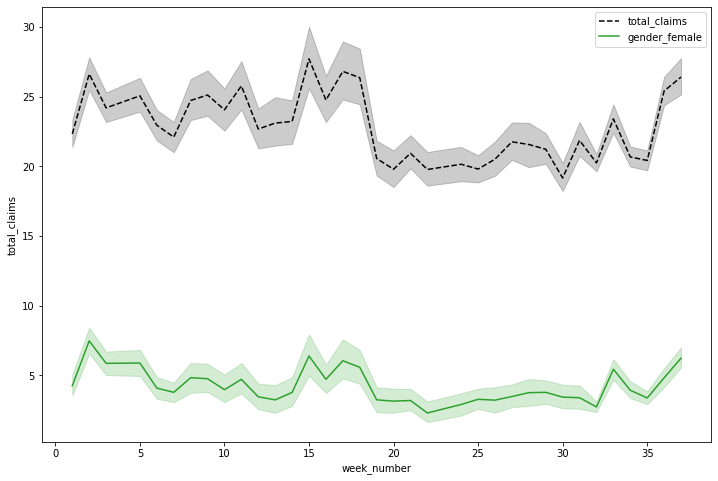

gender_male (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


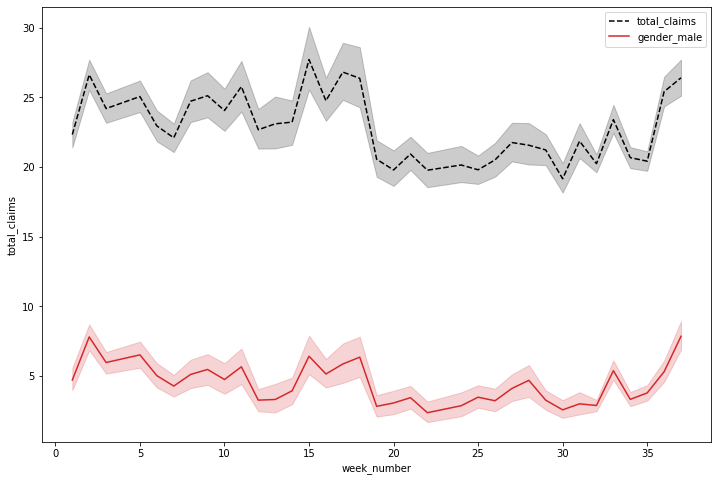

normalized_races (0.5803921568627451, 0.403921568627451, 0.7411764705882353)


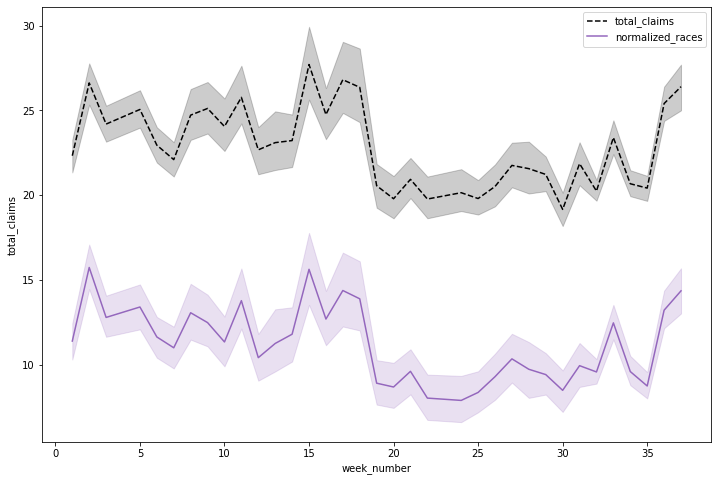

normalized_education (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)


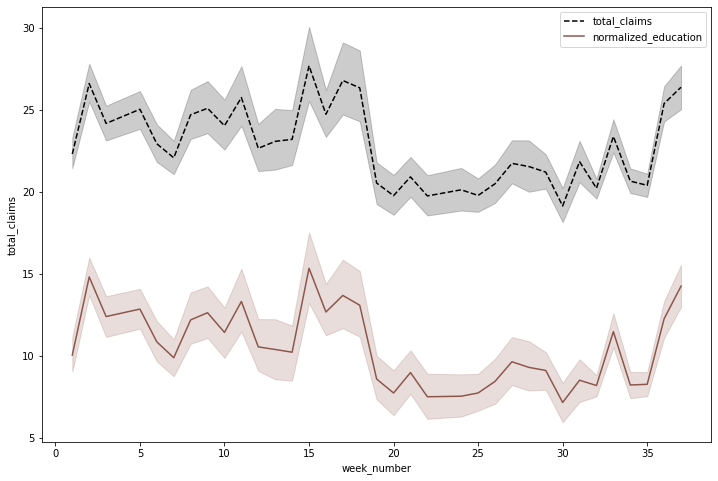

normalized_gender (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


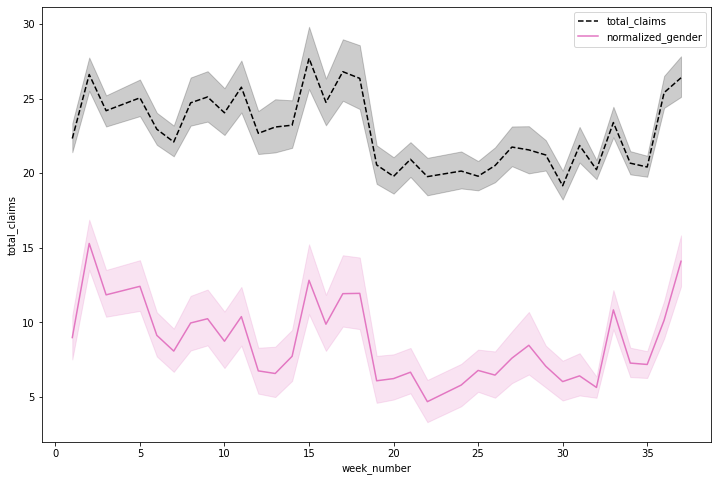

sum (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)


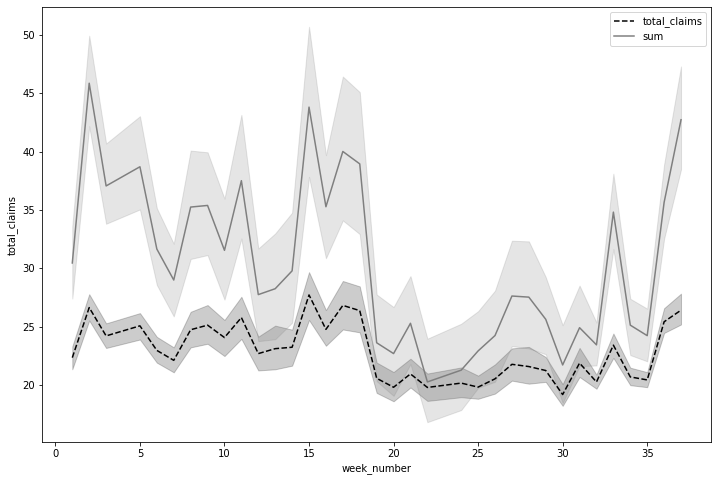

opt_var (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)


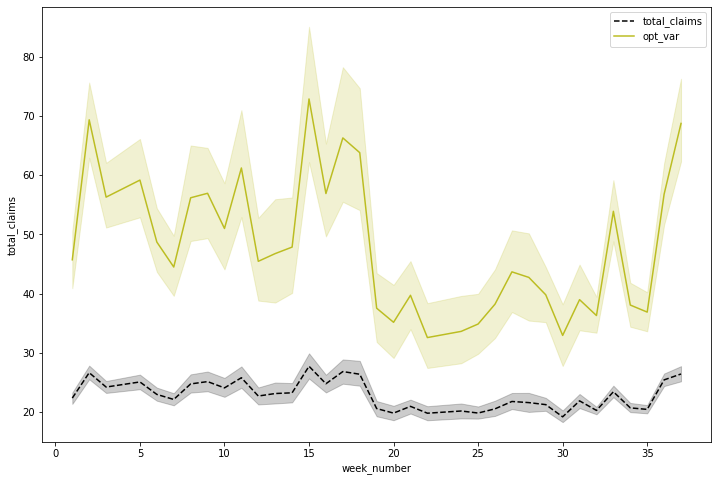

opt_var2 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)


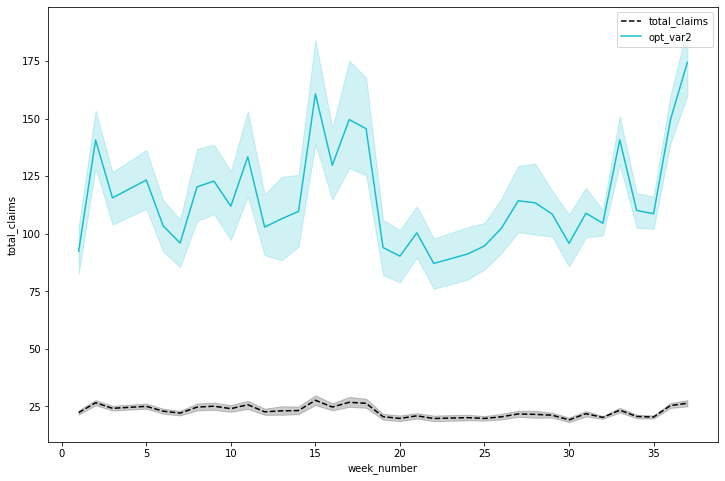

error (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


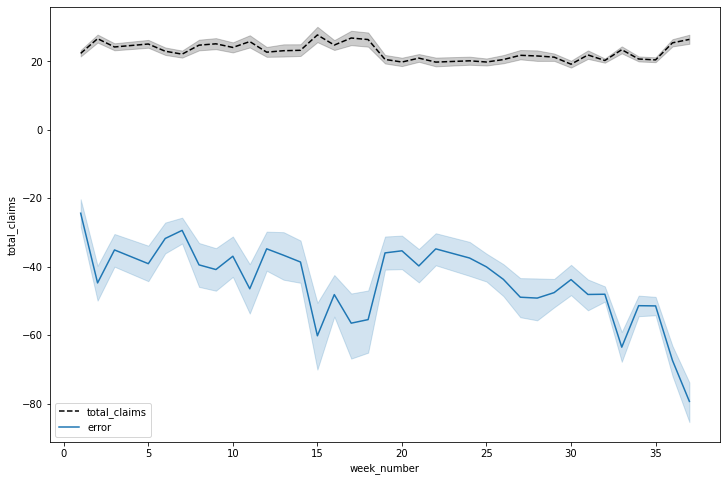

In [30]:
import itertools
colors = itertools.cycle(sns.color_palette("tab10"))
for feature in features:
    fig, ax = plt.subplots(figsize=(12,8)) 
    c = next(colors)
    print(feature, c)
    #sns.scatterplot(x= feature, y = "week_number", data =df3)
    sns.lineplot(y= "total_claims", x = "week_number", data =df3, color = "black", label = "total_claims", linestyle= "--")
    sns.lineplot(y= feature, x = "week_number", data =df3, color = c, label = feature)
    plt.show()

In [31]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as rg
sc = StandardScaler()

In [32]:
def final_pred(t):
    Y = np.array(t["total_claims"])
    X = np.array(t[[k for k in features]])
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size =0.01, random_state =5)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    rf = rg(n_estimators=1000, random_state=2)
    rf.fit(X_train, Y_train)
    return rf

In [33]:
temp = df3[[k for k in features]]
temp

,total_claims,edu_hs_grad_equiv,gender_female,gender_male,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,22.0,14.0,0.0,0.0,11.0,14.0,0.0,25.0,44.816011,105.632023,-38.816011
1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...
16828,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,16.0,10.0,0.0,0.0,0.0,10.0,0.0,10.0,25.726515,82.453030,-40.726515
16831,23.0,19.0,0.0,0.0,0.0,19.0,0.0,19.0,49.179821,107.359642,-35.179821


In [34]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [35]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

In [36]:
test_df.drop_duplicates()

,uu_id,week_number,day,month
0,5bf51fc2e162d6faf9e3cf79e4198378,44,6,11
1,420b44cc7e3f55d738df565421e59941,44,6,11
2,e39c66ecceec76ee8f9f811fa4a2d246,44,6,11
3,a90462cd11ae4e43144239bf7c4828a4,44,6,11
4,8b20a6749088c7ff1237983076ebfeaa,44,6,11
...,...,...,...,...
520,46c4f6c75e663b1ca82ea7994e6d83d3,44,6,11
521,1deebda501712e7595b531b8337bc31a,44,6,11
522,5a9758f65f001b6432ff31ff64a459d7,44,6,11
523,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,6,11


In [37]:
"""extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())
extra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]
extra"""

'extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())\nextra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]\nextra'

In [38]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id").drop(["uu_id"], axis=1).drop_duplicates()
feature_test_pred = test_df.copy()
test_df

,week_number,day,month,uu_id_enc
0,44,6,11,198.0
10,44,6,11,126.0
18,44,6,11,476.0
32,44,6,11,353.0
58,44,6,11,288.0
...,...,...,...,...
16684,44,6,11,144.0
16722,44,6,11,52.0
16757,44,6,11,192.0
16781,44,6,11,486.0


In [39]:
"""test_df1=test_df.copy()
for col in ['total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in extra:
        #test_df.loc[test_df.uu_id_enc==k,col] =0
        temp=df[df.uu_id_enc == k]
        temp["average_wage"]=-9999
        temp =temp.replace("",0)
        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])
        #print(k, temp)
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        idk = float(val.predict(np.array(feature_test_pred))[0])
        print(idk)
        test_df.loc[test_df.uu_id_enc==k,col].value  = idk
test_df"""

'test_df1=test_df.copy()\nfor col in [\'total_claims\', \'edu_8th_or_less\', \'edu_grades_9_11\',\n       \'edu_hs_grad_equiv\', \'edu_post_hs\', \'edu_unknown\',\n       \'top_category_employer1\', \'top_category_employer2\',\n       \'top_category_employer3\', \'gender_female\', \'gender_male\', \'gender_na\',\n       \'race_amerindian\', \'race_asian\', \'race_black\', \'race_noanswer\',\n       \'race_hawaiiannative\', \'race_other\', \'race_white\', \'average_wage\']:\n    print(col)\n    test_df[col]=0\n    val = ("rf")+"_"+str(col) \n    for k in extra:\n        #test_df.loc[test_df.uu_id_enc==k,col] =0\n        temp=df[df.uu_id_enc == k]\n        temp["average_wage"]=-9999\n        temp =temp.replace("",0)\n        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])\n        #print(k, temp)\n        val = time_pred(temp, col)\n        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))\n        idk = float(val.predict(np.array(featur

In [40]:
df3

,uu_id,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,f013068de98db1470bd986137a0c6d23,16.0,18003.0,900.0,451,22.0,0.0,0.0,14.0,0.0,...,4.0,16.0,494.0,11.0,14.0,0.0,25.0,44.816011,105.632023,-38.816011
1,f013068de98db1470bd986137a0c6d23,7.0,18003.0,900.0,451,10.0,0.0,0.0,0.0,0.0,...,2.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,f013068de98db1470bd986137a0c6d23,35.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,8.0,27.0,494.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,f013068de98db1470bd986137a0c6d23,11.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,3.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,f013068de98db1470bd986137a0c6d23,6.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,2.0,5.0,494.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,33f8f477e670b3cac704f4c0faa6e318,10.0,18113.0,971900.0,516,11.0,0.0,0.0,0.0,0.0,...,3.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,33f8f477e670b3cac704f4c0faa6e318,6.0,18113.0,971900.0,516,10.0,0.0,0.0,0.0,0.0,...,2.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,33f8f477e670b3cac704f4c0faa6e318,31.0,18113.0,971900.0,516,16.0,0.0,0.0,10.0,0.0,...,7.0,30.0,100.0,0.0,10.0,0.0,10.0,25.726515,82.453030,-40.726515
16831,33f8f477e670b3cac704f4c0faa6e318,9.0,18113.0,971900.0,516,23.0,0.0,0.0,19.0,0.0,...,2.0,26.0,100.0,0.0,19.0,0.0,19.0,49.179821,107.359642,-35.179821


In [41]:
from statsmodels.tsa.stattools import adfuller
adfuller(df3["total_claims"])

(-15.17531611425783,
 6.306874201042166e-28,
 25,
 16807,
 {'1%': -3.430739141371555,
  '5%': -2.8617119850098525,
  '10%': -2.566861543233935},
 134499.30246634077)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

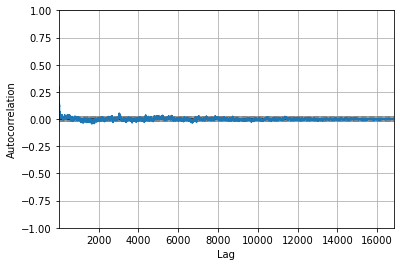

In [42]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df3["total_claims"])

In [43]:
df3 =df3.dropna()
for col in features:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in df3.uu_id_enc.unique():
        temp=df3[df3.uu_id_enc == k]
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        test_df.loc[test_df.uu_id_enc==k,col] = val.predict(np.array(feature_test_pred))[0]
test_df

total_claims


NameError: name 'time_pred' is not defined

In [44]:
#df3 =df3.dropna()
li=[]
import statsmodels.api as sm
import statistics    
for k in df3.uu_id_enc.unique():
    temp=df3[df3.uu_id_enc == k]
    temp = temp.sort_values("week_number")
    df3_ = pd.concat([temp,test_df])
    df3_=df3_[["week_number","uu_id_enc","total_claims"]].drop_duplicates()
    #df3_["predicted_total_claims"]=0
    mod = sm.tsa.statespace.SARIMAX(np.array(temp["total_claims"]),
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 2),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    try: 
        results = mod.fit()
    except IndexError:
        g = df3[df3.uu_id_enc==k]
        val= g[g.week_number==39]['total_claims'].mean()
    pred = results.get_prediction(start=40, end =40, dynamic=False)
    val = (pred.predicted_mean)
    test_df.loc[test_df.uu_id_enc==k,"total_claims"] = val
    li.append(pred.predicted_mean)
    pred_ci = pred.conf_int()
    #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51304D+00    |proj g|=  7.30584D-02

At iterate    5    f=  2.36879D+00    |proj g|=  3.32269D-01

At iterate   10    f=  2.23125D+00    |proj g|=  8.98108D-02

At iterate   15    f=  2.21721D+00    |proj g|=  5.26167D-02

At iterate   20    f=  2.21388D+00    |proj g|=  5.54893D-03

At iterate   25    f=  2.21384D+00    |proj g|=  5.16791D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  4.18124D+00    |proj g|=  3.51362D-02

At iterate   25    f=  4.15755D+00    |proj g|=  1.31426D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   2.262D-05   4.158D+00
  F =   4.1575452566924431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11067D+00    |proj g|=  1.42801D-01

At iterate    5    f=  4.05220D+00    |proj g|=  1.06213D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.75969D+00    |proj g|=  2.61935D-02

At iterate   15    f=  2.75516D+00    |proj g|=  4.29083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   5.062D-06   2.755D+00
  F =   2.7551425234405076     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16797D+00    |proj g|=  6.64345D-02

At iterate    5    f=  3.03233D+00    |proj g|=  1.15997D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.57012D+00    |proj g|=  1.88926D-02

At iterate   15    f=  1.55622D+00    |proj g|=  1.56162D-02

At iterate   20    f=  1.55615D+00    |proj g|=  4.52591D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   4.526D-06   1.556D+00
  F =   1.5561496342413650     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41334D+00    |proj g|=  9.16508D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


At iterate   10    f=  3.17927D+00    |proj g|=  4.65534D-03

At iterate   15    f=  3.17922D+00    |proj g|=  1.96243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   8.329D-06   3.179D+00
  F =   3.1792209601242849     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46963D+00    |proj g|=  7.38843D-02

At iterate    5    f=  1.44362D+00    |proj g|=  2.27554D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.75771D+00    |proj g|=  2.74771D-02

At iterate   10    f=  2.75654D+00    |proj g|=  4.56905D-04

At iterate   15    f=  2.75653D+00    |proj g|=  2.68043D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     21      1     0     0   2.680D-06   2.757D+00
  F =   2.7565332919450927     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98088D+00    |proj g|=  8.49888D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.51069D+00    |proj g|=  2.69099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     23      1     0     0   6.371D-06   3.511D+00
  F =   3.5106877673680708     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48428D+00    |proj g|=  1.04692D-01

At iterate    5    f=  3.44432D+00    |proj g|=  2.58522D-02

At iterate   10    f=  3.39994D+00    |proj g|=  1.26852D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66935D+00    |proj g|=  1.28312D-01

At iterate    5    f=  2.62110D+00    |proj g|=  1.82379D-01

At iterate   10    f=  2.60482D+00    |proj g|=  1.40955D-03

At iterate   15    f=  2.60046D+00    |proj g|=  1.77326D-01

At iterate   20    f=  2.59637D+00    |proj g|=  1.88826D-01

At iterate   25    f=  2.59429D+00    |proj g|=  2.44035D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     70      2     0     0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48398D+00    |proj g|=  1.78410D-01

At iterate    5    f=  2.34868D+00    |proj g|=  1.36966D-01

At iterate   10    f=  2.27979D+00    |proj g|=  8.36548D-02

At iterate   15    f=  2.26810D+00    |proj g|=  1.62875D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   5.020D-07   2.268D+00
  F =   2.2681003422654724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.50878D+00    |proj g|=  5.99518D-02

At iterate   10    f=  3.41728D+00    |proj g|=  1.15659D-01

At iterate   15    f=  3.39129D+00    |proj g|=  7.45721D-02

At iterate   20    f=  3.36723D+00    |proj g|=  7.12457D-02

At iterate   25    f=  3.36569D+00    |proj g|=  6.43563D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     43      1     0     0   9.818D-06   3.366D+00
  F =   3.3656934923641613     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62183D+00    |proj g|=  1.30069D-01

At iterate    5    f=  2.57527D+00    |proj g|=  2.09340D-02

At iterate   10    f=  2.56850D+00    |proj g|=  6.13623D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.186D-05   2.569D+00
  F =   2.5685020499014621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.26623D+00    |proj g|=  7.33345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   2.298D-06   2.266D+00
  F =   2.2662288284247225     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09428D+00    |proj g|=  9.52733D-02

At iterate    5    f=  3.04565D+00    |proj g|=  1.49146D-02

At iterate   10    f=  3.03152D+00    |proj g|=  9.17963D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.68853D+00    |proj g|=  7.84478D-03

At iterate   20    f=  1.68652D+00    |proj g|=  1.13476D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   9.164D-06   1.687D+00
  F =   1.6865143027773519     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00714D+00    |proj g|=  8.08403D-02

At iterate    5    f=  2.96078D+00    |proj g|=  2.23447D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20648D+00    |proj g|=  5.23864D-02

At iterate    5    f=  3.18777D+00    |proj g|=  5.16908D-02

At iterate   10    f=  3.11299D+00    |proj g|=  3.11867D-02

At iterate   15    f=  3.11090D+00    |proj g|=  2.69828D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   8.107D-06   3.111D+00
  F =   3.1109029154420131     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.97865D+00    |proj g|=  1.96913D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   9.000D-06   2.979D+00
  F =   2.9786487505586421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64243D+00    |proj g|=  2.00479D-01

At iterate    5    f=  3.58942D+00    |proj g|=  4.32960D-02

At iterate   10    f=  3.54595D+00    |proj g|=  6.70015D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.56522D+00    |proj g|=  2.79385D-01

At iterate   10    f=  1.55179D+00    |proj g|=  5.51771D-02

At iterate   15    f=  1.53977D+00    |proj g|=  8.95636D-02

At iterate   20    f=  1.53472D+00    |proj g|=  3.29961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   4.274D-06   1.535D+00
  F =   1.5347150909373197     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.00314D+00    |proj g|=  1.54711D-02

At iterate   25    f=  2.00297D+00    |proj g|=  1.32451D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     34      1     0     0   1.325D-05   2.003D+00
  F =   2.0029679200827313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33218D+00    |proj g|=  3.21565D-02

At iterate    5    f=  3.30529D+00    |proj g|=  1.78610D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.894D-06   2.272D+00
  F =   2.2722855009881364     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95455D+00    |proj g|=  1.12924D-01

At iterate    5    f=  3.91720D+00    |proj g|=  2.00189D-02

At iterate   10    f=  3.85391D+00    |proj g|=  9.36485D-02

At iterate   15    f=  3.76576D+00    |proj g|=  2.21406D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.27814D+00    |proj g|=  1.20262D-01

At iterate   15    f=  3.20984D+00    |proj g|=  2.48691D-02

At iterate   20    f=  3.20937D+00    |proj g|=  6.37129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     40      1     0     0   9.095D-05   3.209D+00
  F =   3.2093662601116337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64235D+00    |proj g|=  1.37768D-01

At iter

 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate co


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47    204      3     0     0   4.599D+01  -6.919D-01
  F = -0.69185507077376540     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76925D+00    |proj g|=  1.84786D-01

At iterate    5    f=  2.72225D+00    |proj g|=  1.79064D-02

At iterate   10    f=  2.69134D+00    |proj g|=  5.74372D-02

At iterate   15    f=  2.68564D+00    |proj g|=  2.58385D-03

At iter

 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     31      1     0     0   4.066D-06   3.041D+00
  F =   3.0405370908596847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44574D+00    |proj g|=  1.20205D-01

At iterate    5    f=  3.40112D+00    |proj g|=  4.30936D-02

At iterate   10    f=  3.38887D+00    |proj g|=  3.87741D-02

At iterate   15    f=  3.34257D+00    |proj g|=  4.35269D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  3.07644D+00    |proj g|=  1.51501D-02

At iterate   15    f=  3.07418D+00    |proj g|=  6.48097D-02

At iterate   20    f=  3.07348D+00    |proj g|=  4.05448D-03

At iterate   25    f=  3.07346D+00    |proj g|=  9.93345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   1.178D-05   3.073D+00
  F =   3.0734556553082419     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32974D+00    |proj g|=  1.36112D-01

At iterate    5    f=  3.28513D+00    |proj g|=  1.30814D-01

At iterate   10    f=  3.26388D+00    |proj g|=  4.67565D-02

At iterate   15    f=  3.17296D+00    |proj g|=  2.25408D-01

At iterate   20    f=  3.16934D+00    |proj g|=  4.34572D-03

At iterate   25    f=  3.16933D+00    |proj g|=  8.16777D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   8.168D-05   3.169D+00
  F =   3.1693276327813

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.86586D+00    |proj g|=  2.48692D-02

At iterate   15    f=  1.86474D+00    |proj g|=  3.12577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   6.854D-06   1.865D+00
  F =   1.8646983397460737     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87682D+00    |proj g|=  1.86285D-01

At iterate    5    f=  2.79079D+00    |proj g|=  4.65121D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.55519D+00    |proj g|=  2.11571D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   2.464D-06   3.555D+00
  F =   3.5551898027030777     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16777D+00    |proj g|=  2.33053D-01

At iterate    5    f=  3.11716D+00    |proj g|=  4.94557D-02

At iterate   10    f=  2.99051D+00    |proj g|=  6.11639D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.90245D+00    |proj g|=  1.26265D-01

At iterate   20    f=  3.88847D+00    |proj g|=  1.11921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   3.635D-05   3.888D+00
  F =   3.8884667704934039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10138D+00    |proj g|=  1.25496D-01

At iterate    5    f=  4.06345D+00    |proj g|=  1.60121D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48956D+00    |proj g|=  7.54736D-02

At iterate    5    f=  3.45503D+00    |proj g|=  1.56326D-01

At iterate   10    f=  3.42720D+00    |proj g|=  6.47936D-02

At iterate   15    f=  3.34824D+00    |proj g|=  1.88587D-02

At iterate   20    f=  3.34777D+00    |proj g|=  8.73319D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   8.733D-06   3.348D+00
  F =   3.3477709895710004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   1.724D-05   3.586D+00
  F =   3.5855151352848877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13929D+00    |proj g|=  2.29659D-01

At iterate    5    f=  3.07091D+00    |proj g|=  4.98662D-02

At iterate   10    f=  3.02525D+00    |proj g|=  1.05048D-01

At iterate   15    f=  2.97204D+00    |proj g|=  1.09484D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.09377D+00    |proj g|=  1.87274D-01

At iterate   15    f=  3.08294D+00    |proj g|=  2.14260D-02

At iterate   20    f=  3.08249D+00    |proj g|=  8.23311D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   7.167D-07   3.082D+00
  F =   3.0824901957586066     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81903D+00    |proj g|=  6.40208D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.26878D+00    |proj g|=  1.30670D-01

At iterate   20    f=  3.26828D+00    |proj g|=  2.72950D-03

At iterate   25    f=  3.26824D+00    |proj g|=  1.52013D-03

At iterate   30    f=  3.26823D+00    |proj g|=  2.90617D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     36      1     0     0   4.398D-05   3.268D+00
  F =   3.2682342335361318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.29653D+00    |proj g|=  3.21734D-01

At iterate   10    f=  1.28024D+00    |proj g|=  1.08510D-02

At iterate   15    f=  1.28003D+00    |proj g|=  1.77741D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     35      1     0     0   1.457D-05   1.280D+00
  F =   1.2800324832472714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00540D+00    |proj g|=  2.44105D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13042D+00    |proj g|=  8.07076D-02

At iterate    5    f=  3.07078D+00    |proj g|=  1.01509D-01

At iterate   10    f=  2.97526D+00    |proj g|=  1.77152D-01

At iterate   15    f=  2.94304D+00    |proj g|=  8.60667D-03

At iterate   20    f=  2.93299D+00    |proj g|=  2.55322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   1.631D-05   2.933D+00
  F =   2.9329807878687699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47909D+00    |proj g|=  7.20604D-02

At iterate    5    f=  2.46386D+00    |proj g|=  2.92143D-02

At iterate   10    f=  2.43300D+00    |proj g|=  8.22100D-03
  ys=-2.481E-03  -gs= 8.767E-04 BFGS update SKIPPED

At iterate   15    f=  2.41050D+00    |proj g|=  1.23619D-02

At iterate   20    f=  2.40512D+00    |proj g|=  1.08763D-02

At iterate   25    f=  2.40468D+00    |proj g|=  8.36962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.67405D+00    |proj g|=  1.02274D-01

At iterate   10    f=  2.57029D+00    |proj g|=  1.86268D-02

At iterate   15    f=  2.56970D+00    |proj g|=  2.46763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   5.639D-06   2.570D+00
  F =   2.5696966222202553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25307D+00    |proj g|=  6.10001D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.63998D+00    |proj g|=  6.36137D-02

At iterate   15    f=  3.56863D+00    |proj g|=  1.45598D-01

At iterate   20    f=  3.52909D+00    |proj g|=  8.82966D-02

At iterate   25    f=  3.52322D+00    |proj g|=  4.69387D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     38      1     0     0   2.988D-05   3.523D+00
  F =   3.5232184435753573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.68430D+00    |proj g|=  2.58712D-01

At iterate   25    f=  3.67152D+00    |proj g|=  8.09489D-03

At iterate   30    f=  3.67151D+00    |proj g|=  3.80442D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     41      1     0     0   3.804D-06   3.672D+00
  F =   3.6715082076903629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70958D+00    |proj g|=  1.34483D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   15    f=  3.19457D+00    |proj g|=  4.01482D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   3.929D-05   3.195D+00
  F =   3.1945565224174337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.95323D+15

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.41649D+00    |proj g|=  4.20900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   2.207D-05   2.416D+00
  F =   2.4164863920074771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49579D+00    |proj g|=  9.57818D-01

At iterate    5    f=  2.23405D+00    |proj g|=  4.58770D-02

At iterate   10    f=  2.21071D+00    |proj g|=  1.03456D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.76980D+00    |proj g|=  3.17767D-02

At iterate   10    f=  2.75973D+00    |proj g|=  6.89167D-02

At iterate   15    f=  2.72933D+00    |proj g|=  5.24723D-02

At iterate   20    f=  2.72069D+00    |proj g|=  2.41057D-03

At iterate   25    f=  2.72069D+00    |proj g|=  1.03097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   1.031D-04   2.721D+00
  F =   2.7206869596957057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.07046D+00    |proj g|=  5.88403D-03

At iterate   15    f=  2.06975D+00    |proj g|=  9.89954D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     31      1     1     0   8.626D-05   2.070D+00
  F =   2.0697535018583544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83427D+00    |proj g|=  2.47233D-01

At iterate    5    f=  3.79335D+00    |proj g|=  1.63312D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.46544D+00    |proj g|=  2.11821D-01

At iterate   25    f=  3.45987D+00    |proj g|=  4.58346D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     44      1     0     0   1.636D-05   3.460D+00
  F =   3.4598503505650444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96058D+00    |proj g|=  2.30617D-01

At iterate    5    f=  2.65101D+00    |proj g|=  7.43121D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.31542D+00    |proj g|=  6.25215D-02

At iterate   20    f=  3.30725D+00    |proj g|=  1.54410D-02

At iterate   25    f=  3.30709D+00    |proj g|=  1.74669D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     37      1     0     0   4.974D-06   3.307D+00
  F =   3.3070844712319136     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90139D+00    |proj g|=  5.97246D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.54931D+00    |proj g|=  7.61926D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     96      3     0     0   6.036D-02   1.549D+00
  F =   1.5493108944002290     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91605D+00    |proj g|=  9.04422D-02

At iterate    5    f=  2.86835D+00    |proj g|=  4.41854D-02

At iterate   10    f=  2.73556D+00    |proj g|=  1.46255D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58121D+00    |proj g|=  1.80354D-01

At iterate    5    f=  2.50069D+00    |proj g|=  1.00935D-01

At iterate   10    f=  2.46501D+00    |proj g|=  3.90325D-02

At iterate   15    f=  2.45913D+00    |proj g|=  1.54944D-02

At iterate   20    f=  2.45887D+00    |proj g|=  2.25390D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   1.614D-06   2.459D+00
  F =   2.4588724114455913     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.88468D+00    |proj g|=  1.99224D-03

At iterate   20    f=  1.88464D+00    |proj g|=  5.48781D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   8.720D-06   1.885D+00
  F =   1.8846407271882670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23312D+00    |proj g|=  3.35289D-02

At iterate    5    f=  2.18248D+00    |proj g|=  2.89534D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.24391D+00    |proj g|=  8.39174D-02

At iterate   10    f=  2.13290D+00    |proj g|=  1.05488D-01

At iterate   15    f=  2.11395D+00    |proj g|=  3.84669D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   9.859D-06   2.114D+00
  F =   2.1138918314144064     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23662D+00    |proj g|=  5.54544D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81371D+00    |proj g|=  1.73386D-01

At iterate    5    f=  2.71208D+00    |proj g|=  1.02022D-01

At iterate   10    f=  2.62793D+00    |proj g|=  3.52513D-02

At iterate   15    f=  2.62247D+00    |proj g|=  2.33589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   3.761D-07   2.622D+00
  F =   2.6224651116243272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.17059D+00    |proj g|=  1.07054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   3.719D-05   3.171D+00
  F =   3.1705853758293823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89839D+00    |proj g|=  3.51528D-02

At iterate    5    f=  1.88867D+00    |proj g|=  2.86073D-02

At iterate   10    f=  1.88052D+00    |proj g|=  2.12880D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.81672D+00    |proj g|=  9.67331D-02

At iterate   20    f=  3.77820D+00    |proj g|=  4.16210D-02

At iterate   25    f=  3.77534D+00    |proj g|=  1.27243D-04

At iterate   30    f=  3.77534D+00    |proj g|=  2.86430D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     46      1     0     0   2.050D-05   3.775D+00
  F =   3.7753366194747184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.34243D+00    |proj g|=  1.44632D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.070D-06   2.342D+00
  F =   2.3424279093826299     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25613D+00    |proj g|=  5.11268D-02

At iterate    5    f=  3.23298D+00    |proj g|=  1.96476D-02

At iterate   10    f=  3.22694D+00    |proj g|=  4.23716D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.30943D+00    |proj g|=  1.65693D-01

At iterate   20    f=  3.27180D+00    |proj g|=  1.25234D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     36      1     0     0   5.494D-06   3.272D+00
  F =   3.2716685464251749     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54484D+00    |proj g|=  8.07847D-02

At iterate    5    f=  3.49130D+00    |proj g|=  1.25295D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.35442D+00    |proj g|=  2.39361D-02

At iterate   15    f=  3.31859D+00    |proj g|=  1.09611D-01

At iterate   20    f=  3.27025D+00    |proj g|=  3.21043D-02

At iterate   25    f=  3.26974D+00    |proj g|=  1.49022D-03

At iterate   30    f=  3.26973D+00    |proj g|=  4.60665D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     39      1     0     0   4.607D-05   3.270D+00
  F =   3.2697322557161521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.87874D+00    |proj g|=  3.82955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     40      1     0     0   3.830D-04   2.879D+00
  F =   2.8787396328554600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81717D+00    |proj g|=  8.50286D-02

At iterate    5    f=  3.80103D+00    |proj g|=  3.23231D-02

At iterate   10    f=  3.72393D+00    |proj g|=  1.25919D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  2.60452D+00    |proj g|=  5.53568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     43      1     0     0   1.669D-04   2.605D+00
  F =   2.6045174844103989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91300D+00    |proj g|=  1.05157D-01

At iterate    5    f=  3.86609D+00    |proj g|=  3.25846D-02

At iterate   10    f=  3.85412D+00    |proj g|=  3.32232D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.34913D+00    |proj g|=  1.41819D-02

At iterate   20    f=  3.34902D+00    |proj g|=  3.76687D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   8.232D-06   3.349D+00
  F =   3.3490210997198036     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74374D+00    |proj g|=  1.18794D-01

At iterate    5    f=  3.69593D+00    |proj g|=  1.10115D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.125D-05   2.857D+00
  F =   2.8573208615254289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12060D+00    |proj g|=  8.26323D-02

At iterate    5    f=  3.09594D+00    |proj g|=  6.93683D-02

At iterate   10    f=  2.99543D+00    |proj g|=  1.20205D-01

At iterate   15    f=  2.99407D+00    |proj g|=  8.83278D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.84081D+00    |proj g|=  1.92214D-01

At iterate   20    f=  1.83440D+00    |proj g|=  9.41767D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     35      1     0     0   1.167D-06   1.834D+00
  F =   1.8343934254259817     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33652D+00    |proj g|=  7.43399D-02

At iterate    5    f=  3.30569D+00    |proj g|=  1.47309D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.62590D+00    |proj g|=  8.45484D-02

At iterate   15    f=  2.61923D+00    |proj g|=  1.56186D-02

At iterate   20    f=  2.61910D+00    |proj g|=  1.31601D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   1.141D-05   2.619D+00
  F =   2.6190981336849086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01415D+00    |proj g|=  5.58178D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.41942D+00    |proj g|=  1.40983D-01

At iterate   10    f=  3.27631D+00    |proj g|=  6.02304D-02

At iterate   15    f=  3.27154D+00    |proj g|=  1.17881D-03

At iterate   20    f=  3.27103D+00    |proj g|=  1.30977D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     34      1     0     0   6.372D-06   3.271D+00
  F =   3.2710236910687662     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.44139D+00    |proj g|=  1.18691D-01

At iterate   15    f=  2.38888D+00    |proj g|=  1.29949D-02

At iterate   20    f=  2.35032D+00    |proj g|=  3.07042D-02

At iterate   25    f=  2.34952D+00    |proj g|=  7.42052D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   3.917D-06   2.350D+00
  F =   2.3495155468548554     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.07152D+00    |proj g|=  2.36645D-01

At iterate   10    f=  1.98603D+00    |proj g|=  7.92656D-03

At iterate   15    f=  1.98570D+00    |proj g|=  2.94882D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   2.638D-06   1.986D+00
  F =   1.9857009358338391     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09066D+00    |proj g|=  4.82591D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   9.370D-06   1.806D+00
  F =   1.8064754853255589     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18583D+00    |proj g|=  1.96265D-01

At iterate    5    f=  3.12105D+00    |proj g|=  2.96277D-02

At iterate   10    f=  3.03419D+00    |proj g|=  6.75482D-02

At iterate   15    f=  2.99168D+00    |proj g|=  4.41629D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.901D-06   2.747D+00
  F =   2.7469030118365731     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98393D+00    |proj g|=  1.19089D-01

At iterate    5    f=  2.92495D+00    |proj g|=  3.22215D-02

At iterate   10    f=  2.82700D+00    |proj g|=  4.27842D-02

At iterate   15    f=  2.78224D+00    |proj g|=  7.95652D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.27547D+00    |proj g|=  9.57264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   5.300D-05   2.275D+00
  F =   2.2754745163170846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60580D+00    |proj g|=  9.64406D-02

At iterate    5    f=  3.56798D+00    |proj g|=  3.15162D-02

At iterate   10    f=  3.43056D+00    |proj g|=  8.66177D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81419D+00    |proj g|=  1.17624D-01

At iterate    5    f=  2.70842D+00    |proj g|=  9.79116D-02

At iterate   10    f=  2.58061D+00    |proj g|=  2.72059D-02

At iterate   15    f=  2.57612D+00    |proj g|=  2.30148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   5.984D-06   2.576D+00
  F =   2.5761071241553561     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54999D+00    |proj g|=  1.92521D-01

At iterate    5    f=  2.49084D+00    |proj g|=  1.95823D-02

At iterate   10    f=  2.47220D+00    |proj g|=  1.31621D-01

At iterate   15    f=  2.45387D+00    |proj g|=  1.56730D-01

At iterate   20    f=  2.45332D+00    |proj g|=  7.07276D-02

At iterate   25    f=  2.44986D+00    |proj g|=  9.20639D-02

At iterate   30    f=  2.44960D+00    |proj g|=  4.85621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.68194D+00    |proj g|=  3.21432D-02

At iterate   10    f=  3.63379D+00    |proj g|=  1.40587D-01

At iterate   15    f=  3.60151D+00    |proj g|=  5.24973D-04

At iterate   20    f=  3.59948D+00    |proj g|=  3.00226D-02

At iterate   25    f=  3.59730D+00    |proj g|=  4.64204D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     44      1     0     0   6.947D-06   3.597D+00
  F =   3.5973021338023985     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24638D+00    |proj g|=  2.62416D-01

At iterate    5    f=  1.16611D+00    |proj g|=  5.49756D-01

At iterate   10    f=  1.11622D+00    |proj g|=  3.02105D-01

At iterate   15    f=  1.00428D+00    |proj g|=  2.17017D-01

At iterate   20    f=  9.98890D-01    |proj g|=  1.08361D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   9.255D-06   9.989D-01
  F =  0.99888928667236798     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.63229D+00    |proj g|=  1.41171D-01

At iterate   10    f=  2.51058D+00    |proj g|=  1.82823D-02

At iterate   15    f=  2.50997D+00    |proj g|=  4.06674D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.124D-05   2.510D+00
  F =   2.5099676612872739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90509D+00    |proj g|=  9.26164D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.87705D+00    |proj g|=  9.84690D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   9.847D-06   1.877D+00
  F =   1.8770469979910864     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49001D+00    |proj g|=  6.47522D-02

At iterate    5    f=  2.42429D+00    |proj g|=  1.47543D-01

At iterate   10    f=  2.32791D+00    |proj g|=  1.60725D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16695D+00    |proj g|=  1.57448D-01

At iterate    5    f=  2.09088D+00    |proj g|=  6.73061D-02

At iterate   10    f=  2.05732D+00    |proj g|=  1.04541D-02

At iterate   15    f=  2.05725D+00    |proj g|=  6.20914D-04

At iterate   20    f=  2.05725D+00    |proj g|=  1.07545D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   1.075D-05   2.057D+00
  F =   2.0572478662827098     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.15100D+00    |proj g|=  3.61407D-02

At iterate   20    f=  2.15096D+00    |proj g|=  9.36192D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     35      1     0     0   1.292D-04   2.151D+00
  F =   2.1509632800232512     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19870D+00    |proj g|=  8.86999D-02

At iterate    5    f=  3.16851D+00    |proj g|=  5.30698D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.30683D+00    |proj g|=  3.78603D-02

At iterate   20    f=  3.30648D+00    |proj g|=  5.06357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   4.250D-06   3.306D+00
  F =   3.3064807776201897     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00616D+00    |proj g|=  1.69254D-01

At iterate    5    f=  1.92942D+00    |proj g|=  5.21551D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.59462D+00    |proj g|=  1.62842D-02

At iterate   20    f=  2.59304D+00    |proj g|=  7.53643D-03

At iterate   25    f=  2.59278D+00    |proj g|=  3.41536D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     39      1     0     0   8.554D-06   2.593D+00
  F =   2.5927827535632200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16278D+00    |proj g|=  1.08302D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.36098D+00    |proj g|=  8.17459D-02

At iterate   15    f=  3.35475D+00    |proj g|=  2.64199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   1.287D-05   3.355D+00
  F =   3.3547274640031306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67305D+00    |proj g|=  4.31029D-01

At iterate    5    f=  2.46983D+00    |proj g|=  5.97815D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55912D+00    |proj g|=  2.43391D-01

At iterate    5    f=  3.46193D+00    |proj g|=  4.84962D-02

At iterate   10    f=  3.44766D+00    |proj g|=  7.30111D-02

At iterate   15    f=  3.36965D+00    |proj g|=  1.53907D-01

At iterate   20    f=  3.31441D+00    |proj g|=  9.76130D-03

At iterate   25    f=  3.31434D+00    |proj g|=  6.24389D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.83040D+00    |proj g|=  1.02242D-02

At iterate   15    f=  2.83002D+00    |proj g|=  3.92785D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.529D-05   2.830D+00
  F =   2.8300190339561833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27429D+00    |proj g|=  7.12110D-02

At iterate    5    f=  3.07349D+00    |proj g|=  3.69694D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.40446D+00    |proj g|=  1.99529D-01

At iterate   10    f=  2.33245D+00    |proj g|=  2.08705D-02

At iterate   15    f=  2.33189D+00    |proj g|=  1.20272D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   4.096D-06   2.332D+00
  F =   2.3318870878331843     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09488D+00    |proj g|=  1.17604D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.62882D+00    |proj g|=  2.24577D-02

At iterate   15    f=  2.62839D+00    |proj g|=  2.80354D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   4.252D-06   2.628D+00
  F =   2.6283853705964488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74765D+00    |proj g|=  5.48845D-02

At iterate    5    f=  2.55976D+00    |proj g|=  1.41503D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70098D+00    |proj g|=  1.75489D-01

At iterate    5    f=  1.62789D+00    |proj g|=  1.18566D-02

At iterate   10    f=  1.59000D+00    |proj g|=  9.00258D-02

At iterate   15    f=  1.56346D+00    |proj g|=  1.86574D-02

At iterate   20    f=  1.56310D+00    |proj g|=  2.29595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     36      1     0     0   7.256D-06   1.563D+00
  F =   1.5630927345296377     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09442D+00    |proj g|=  7.11587D-02

At iterate    5    f=  9.72024D-01    |proj g|=  3.28058D-02

At iterate   10    f=  9.63148D-01    |proj g|=  3.88569D-02

At iterate   15    f=  9.60732D-01    |proj g|=  1.15392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   2.625D-06   9.607D-01
  F =  0.96073128961671550     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50830D+00    |proj g|=  2.52722D-01

At iterate    5    f=  2.46970D+00    |proj g|=  6.08827D-02

At iterate   10    f=  2.36055D+00    |proj g|=  1.00270D-01

At iterate   15    f=  2.35730D+00    |proj g|=  6.66743D-03

At iterate   20    f=  2.35728D+00    |proj g|=  5.60644D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     34      1     0     0   9.721D-05   2.357D+00
  F =   2.3572820521779283     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.14017D+00    |proj g|=  1.08045D-02

At iterate   20    f=  3.13999D+00    |proj g|=  2.88804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     39      1     0     0   1.329D-04   3.140D+00
  F =   3.1399926617040137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24158D+00    |proj g|=  1.23973D-01

At iterate    5    f=  3.16946D+00    |proj g|=  2.04424D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.42511D+00    |proj g|=  5.63011D-01

At iterate   20    f=  1.38846D+00    |proj g|=  1.69503D-02

At iterate   25    f=  1.38774D+00    |proj g|=  3.50939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     38      1     0     0   2.318D-06   1.388D+00
  F =   1.3877426640724433     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88911D+00    |proj g|=  1.34620D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76770D+00    |proj g|=  2.01456D-01

At iterate    5    f=  2.61883D+00    |proj g|=  8.50128D-02

At iterate   10    f=  2.60596D+00    |proj g|=  1.33323D-02

At iterate   15    f=  2.60562D+00    |proj g|=  1.26896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     26      1     0     0   4.147D-06   2.606D+00
  F =   2.6056226268105700     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.41670D+00    |proj g|=  2.16586D-02

At iterate   10    f=  3.32836D+00    |proj g|=  1.06474D-01

At iterate   15    f=  3.17177D+00    |proj g|=  7.20604D-02

At iterate   20    f=  3.15657D+00    |proj g|=  1.84221D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     34      1     0     0   2.944D-05   3.157D+00
  F =   3.1565669911699952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   25    f=  1.65221D+00    |proj g|=  4.48520D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     42      1     0     0   2.850D-05   1.652D+00
  F =   1.6522091940956323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71042D+00    |proj g|=  8.90918D-02

At iterate    5    f=  3.68923D+00    |proj g|=  3.38320D-02

At iterate   10    f=  3.58874D+00    |proj g|=  1.14002D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.44894D+00    |proj g|=  4.99572D-02

At iterate   10    f=  3.29834D+00    |proj g|=  7.66052D-02

At iterate   15    f=  3.28663D+00    |proj g|=  6.16327D-03

At iterate   20    f=  3.28461D+00    |proj g|=  1.83878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     30      1     0     0   1.215D-06   3.285D+00
  F =   3.2846128146670539     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.27720D+00    |proj g|=  1.02495D-01

At iterate   20    f=  3.25934D+00    |proj g|=  2.58518D-03

At iterate   25    f=  3.25930D+00    |proj g|=  1.51745D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   1.517D-06   3.259D+00
  F =   3.2593006256855523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48627D+00    |proj g|=  5.33719D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.79743D+00    |proj g|=  1.08242D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     27      1     0     0   5.834D-05   2.797D+00
  F =   2.7974280920263790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04403D+00    |proj g|=  1.08010D-01

At iterate    5    f=  4.02310D+00    |proj g|=  1.92896D-02

At iterate   10    f=  3.96816D+00    |proj g|=  1.36004D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.60141D+00    |proj g|=  4.41482D-02

At iterate   10    f=  2.55144D+00    |proj g|=  8.79283D-02

At iterate   15    f=  2.52737D+00    |proj g|=  3.31338D-02

At iterate   20    f=  2.52713D+00    |proj g|=  4.90443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   4.738D-05   2.527D+00
  F =   2.5271265725631999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.67295D+00    |proj g|=  1.62917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     33      1     0     0   1.174D-05   2.673D+00
  F =   2.6729455222825798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52548D+00    |proj g|=  2.40595D-01

At iterate    5    f=  2.45035D+00    |proj g|=  7.81317D-02

At iterate   10    f=  2.44349D+00    |proj g|=  1.31347D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.85128D+00    |proj g|=  3.97205D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.048D-07   2.851D+00
  F =   2.8512760097845340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39356D+00    |proj g|=  1.00196D-01

At iterate    5    f=  3.34951D+00    |proj g|=  5.11550D-02

At iterate   10    f=  3.28567D+00    |proj g|=  9.97282D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.30463D+00    |proj g|=  1.71809D-01

At iterate   15    f=  3.21996D+00    |proj g|=  4.31216D-02

At iterate   20    f=  3.21824D+00    |proj g|=  1.35106D-03

At iterate   25    f=  3.21824D+00    |proj g|=  8.09934D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   8.099D-06   3.218D+00
  F =   3.2182350125200219     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62714D+00    |proj g|=  1.40655D-01

At iterate    5    f=  3.55451D+00    |proj g|=  3.66318D-02

At iterate   10    f=  3.53010D+00    |proj g|=  1.29502D-01

At iterate   15    f=  3.43842D+00    |proj g|=  5.22336D-01

At iterate   20    f=  3.40730D+00    |proj g|=  4.05890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     34      1     0     0   4.261D-06   3.407D+00
  F =   3.4072967581669720     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.41576D+00    |proj g|=  5.55237D-01

At iterate   15    f=  3.37271D+00    |proj g|=  4.90059D-02

At iterate   20    f=  3.37256D+00    |proj g|=  5.29483D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   5.295D-06   3.373D+00
  F =   3.3725626100278312     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52214D+00    |proj g|=  6.06245D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.89251D+00    |proj g|=  4.91433D-02

At iterate   10    f=  3.86183D+00    |proj g|=  5.76604D-02

At iterate   15    f=  3.81718D+00    |proj g|=  9.55140D-02

At iterate   20    f=  3.73489D+00    |proj g|=  7.53048D-02

At iterate   25    f=  3.73298D+00    |proj g|=  7.46670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     43      1     0     0   3.170D-06   3.733D+00
  F =   3.7329553935915398     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.70154D+00    |proj g|=  4.87008D-02

At iterate   25    f=  2.69914D+00    |proj g|=  1.28574D-01

At iterate   30    f=  2.69811D+00    |proj g|=  6.77666D-04

At iterate   35    f=  2.69811D+00    |proj g|=  6.91752D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     46      1     0     0   3.198D-06   2.698D+00
  F =   2.6981102303804989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.96603D+00    |proj g|=  1.37799D-04

At iterate   20    f=  2.96603D+00    |proj g|=  2.59991D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   3.168D-06   2.966D+00
  F =   2.9660308075517321     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83055D+00    |proj g|=  1.48657D-01

At iterate    5    f=  3.77157D+00    |proj g|=  1.50906D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37192D+00    |proj g|=  3.25591D-01

At iterate    5    f=  3.31730D+00    |proj g|=  5.28633D-02

At iterate   10    f=  3.16580D+00    |proj g|=  6.91081D-02

At iterate   15    f=  3.15744D+00    |proj g|=  2.78024D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   1.936D-05   3.157D+00
  F =   3.1574412549633601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.61905D+00    |proj g|=  6.32569D-02

At iterate   15    f=  3.60165D+00    |proj g|=  3.34112D-02

At iterate   20    f=  3.57812D+00    |proj g|=  8.73583D-03

At iterate   25    f=  3.57798D+00    |proj g|=  4.99181D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     35      1     0     0   1.754D-05   3.578D+00
  F =   3.5779762232482435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.71003D+00    |proj g|=  2.72574D-02

At iterate   10    f=  2.62667D+00    |proj g|=  4.90426D-02

At iterate   15    f=  2.61475D+00    |proj g|=  1.91988D-03

At iterate   20    f=  2.61474D+00    |proj g|=  3.60365D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   3.604D-06   2.615D+00
  F =   2.6147379527680346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     53      2     0     0   9.910D+14  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84383D+00    |proj g|=  1.73862D-01

At iterate    5    f=  3.79572D+00    |proj g|=  1.27180D-02

At iterate   10    f=  3.75617D+00    |proj g|=  5.25402D-02

At iterate   15    f=  3.65486D+00    |proj g|=  1.21798D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  2.45919D+00    |proj g|=  3.32857D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.257D-06   2.459D+00
  F =   2.4591855469232122     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08296D+00    |proj g|=  1.34231D-01

At iterate    5    f=  3.00279D+00    |proj g|=  3.35282D-02

At iterate   10    f=  2.95889D+00    |proj g|=  6.05895D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71256D+00    |proj g|=  1.07568D-01

At iterate    5    f=  3.66968D+00    |proj g|=  2.83225D-02

At iterate   10    f=  3.62461D+00    |proj g|=  1.76899D-01

At iterate   15    f=  3.48666D+00    |proj g|=  9.13394D-02

At iterate   20    f=  3.47396D+00    |proj g|=  6.47634D-02

At iterate   25    f=  3.46990D+00    |proj g|=  7.40081D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     45      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


At iterate   20    f=  1.71940D+00    |proj g|=  1.09828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.257D-05   1.719D+00
  F =   1.7194028101423164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86495D+00    |proj g|=  1.60386D-01

At iterate    5    f=  1.82393D+00    |proj g|=  1.02640D-01

At iterate   10    f=  1.77060D+00    |proj g|=  7.82065D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.85134D+00    |proj g|=  2.01573D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     22      1     0     0   8.413D-06   2.851D+00
  F =   2.8513401176423274     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30541D+00    |proj g|=  1.09986D-01

At iterate    5    f=  3.25565D+00    |proj g|=  2.54545D-02

At iterate   10    f=  3.16269D+00    |proj g|=  1.08875D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.57787D+00    |proj g|=  1.12272D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   3.195D-06   2.578D+00
  F =   2.5778700252563236     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91325D+00    |proj g|=  8.21419D-02

At iterate    5    f=  3.88699D+00    |proj g|=  2.59189D-02

At iterate   10    f=  3.77629D+00    |proj g|=  1.78610D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.11800D+00    |proj g|=  1.73005D-01

At iterate   15    f=  3.07248D+00    |proj g|=  1.02174D-01

At iterate   20    f=  3.05333D+00    |proj g|=  2.63827D-03

At iterate   25    f=  3.05333D+00    |proj g|=  3.26672D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   3.267D-06   3.053D+00
  F =   3.0533261324709620     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.95874D+00    |proj g|=  1.28612D-03

At iterate   20    f=  2.95873D+00    |proj g|=  3.75023D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.106D-05   2.959D+00
  F =   2.9587294187588404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41018D+00    |proj g|=  8.88592D-02

At iterate    5    f=  3.36850D+00    |proj g|=  3.81342D-02

At iter

 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   30    f= -4.99429D-01    |proj g|=  8.42996D+01

At iterate   35    f= -5.99158D-01    |proj g|=  1.05706D+02

At iterate   40    f= -6.27972D-01    |proj g|=  4.41963D+00

At iterate   45    f= -6.38140D-01    |proj g|=  1.13887D+02

At iterate   50    f= -6.49659D-01    |proj g|=  6.91658D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    120      1     0     0   6.917D+00  -6.497D-01
  F = -0.64965918662471622     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  2.85253D+00    |proj g|=  4.39150D-03

At iterate   20    f=  2.85249D+00    |proj g|=  3.86916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     66      2     0     0   9.278D-05   2.852D+00
  F =   2.8524923570133205     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14478D+00    |proj g|=  6.22226D-02

At iterate    5    f=  3.05840D+00    |proj g|=  1.16580D-01

At iter

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.10930D+00    |proj g|=  1.45430D-01

At iterate   10    f=  3.04905D+00    |proj g|=  3.26293D-02

At iterate   15    f=  3.04826D+00    |proj g|=  5.28095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   2.830D-06   3.048D+00
  F =   3.0482623655355381     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10468D+00    |proj g|=  1.15263D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.65463D+00    |proj g|=  1.39644D+00

At iterate   25    f=  2.64108D+00    |proj g|=  1.56774D-02

At iterate   30    f=  2.64108D+00    |proj g|=  1.86279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     56      1     0     0   2.763D-03   2.641D+00
  F =   2.6410807651301731     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05903D+00    |proj g|=  1.00185D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.96924D+00    |proj g|=  2.37157D-03

At iterate   20    f=  2.96921D+00    |proj g|=  1.66231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   1.662D-05   2.969D+00
  F =   2.9692144094283148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45283D+00    |proj g|=  4.19577D-02

At iterate    5    f=  3.39452D+00    |proj g|=  2.05172D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  2.68053D+00    |proj g|=  7.40341D-02

At iterate   10    f=  2.63784D+00    |proj g|=  5.79586D-02

At iterate   15    f=  2.63463D+00    |proj g|=  8.86645D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   6.057D-06   2.635D+00
  F =   2.6346098460871641     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60624D+00    |proj g|=  5.50610D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.64994D+00    |proj g|=  2.12291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.230D-05   3.650D+00
  F =   3.6499370037997707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85403D+00    |proj g|=  2.98541D-01

At iterate    5    f=  3.75336D+00    |proj g|=  1.06525D-02

At iterate   10    f=  3.74998D+00    |proj g|=  3.03100D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.75452D+00    |proj g|=  1.65501D-02

At iterate   20    f=  3.75413D+00    |proj g|=  4.39938D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   4.434D-06   3.754D+00
  F =   3.7541251857521729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96807D+00    |proj g|=  1.10022D-01

At iterate    5    f=  2.91635D+00    |proj g|=  5.92452D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.88645D+00    |proj g|=  8.57152D-01

At iterate   15    f=  2.86173D+00    |proj g|=  5.10437D-02

At iterate   20    f=  2.83525D+00    |proj g|=  4.21244D-01

At iterate   25    f=  2.75583D+00    |proj g|=  3.75919D-01

At iterate   30    f=  2.75456D+00    |proj g|=  2.14934D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     46      1     0     0   2.735D-04   2.755D+00
  F =   2.7545591971925005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.57910D+00    |proj g|=  4.68676D-02

At iterate   10    f=  3.54189D+00    |proj g|=  8.71147D-02

At iterate   15    f=  3.42855D+00    |proj g|=  3.94680D-02

At iterate   20    f=  3.41951D+00    |proj g|=  3.53052D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.110D-06   3.420D+00
  F =   3.4195114915885991     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  5.80144D-01    |proj g|=  2.10547D+00

At iterate   10    f=  4.90707D-01    |proj g|=  2.41753D-01

At iterate   15    f=  3.08105D-01    |proj g|=  2.36197D+00

At iterate   20    f=  1.69616D-01    |proj g|=  6.36201D+01

At iterate   25    f= -3.93057D-02    |proj g|=  4.44317D+01

At iterate   30    f= -7.13363D-01    |proj g|=  3.16877D+02

At iterate   35    f= -9.36295D-01    |proj g|=  1.15310D+03

At iterate   40    f= -1.08824D+00    |proj g|=  8.28335D+01

At iterate   45    f= -1.19245D+00    |proj g|=  4.24331D+02
  ys=-5.322E-09  -gs= 1.995E-08 BFGS update SKIPPED

At iterate   50    f= -1.24949D+00    |proj g|=  1.96340D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  2.93048D+00    |proj g|=  3.73803D-02

At iterate   20    f=  2.92972D+00    |proj g|=  2.13932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.294D-06   2.930D+00
  F =   2.9297179237169004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71184D+00    |proj g|=  5.98833D-02

At iterate    5    f=  2.68315D+00    |proj g|=  8.41584D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.59475D+00    |proj g|=  1.02321D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     27      1     0     0   9.539D-06   2.595D+00
  F =   2.5947205212024347     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99723D+00    |proj g|=  8.56720D-02

At iterate    5    f=  2.96792D+00    |proj g|=  8.01052D-02

At iterate   10    f=  2.88290D+00    |proj g|=  1.05449D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  2.48459D+00    |proj g|=  2.10573D-02

At iterate   10    f=  2.41939D+00    |proj g|=  1.42106D-01

At iterate   15    f=  2.40967D+00    |proj g|=  8.11855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   7.865D-06   2.410D+00
  F =   2.4096665381813422     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75438D+00    |proj g|=  2.91043D-01

At itera


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estima

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45376D+00    |proj g|=  4.60516D-01

At iterate    5    f=  3.30144D+00    |proj g|=  3.28040D-02

At iterate   10    f=  3.29349D+00    |proj g|=  3.03053D-02

At iterate   15    f=  3.26827D+00    |proj g|=  2.74850D-02

At iterate   20    f=  3.24949D+00    |proj g|=  5.59227D-02

At iterate   25    f=  3.24878D+00    |proj g|=  7.39125D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     32      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.82977D+00    |proj g|=  4.33485D-02

At iterate   10    f=  2.68034D+00    |proj g|=  9.06558D-02

At iterate   15    f=  2.67073D+00    |proj g|=  1.05795D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   1.157D-05   2.671D+00
  F =   2.6706576187720503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88453D+00    |proj g|=  1.58456D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.07848D+00    |proj g|=  3.55464D-03

At iterate   20    f=  3.07845D+00    |proj g|=  1.61977D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   1.620D-06   3.078D+00
  F =   3.0784480763128572     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13814D+00    |proj g|=  1.04997D-01

At iterate    5    f=  3.07819D+00    |proj g|=  5.54092D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     33      1     0     0   3.789D-06   3.284D+00
  F =   3.2835214391706335     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54165D+00    |proj g|=  8.20651D-02

At iterate    5    f=  3.51492D+00    |proj g|=  2.05126D-02

At iterate   10    f=  3.46069D+00    |proj g|=  2.07098D-01

At iterate   15    f=  3.33908D+00    |proj g|=  9.88463D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   6.920D-06   1.817D+00
  F =   1.8172710773181868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36667D+00    |proj g|=  1.97153D-01

At iterate    5    f=  3.30963D+00    |proj g|=  3.73045D-02

At iterate   10    f=  3.23169D+00    |proj g|=  5.60336D-02

At iterate   15    f=  3.22030D+00    |proj g|=  8.05361D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.39263D+00    |proj g|=  4.29730D-02

At iterate   10    f=  3.21341D+00    |proj g|=  6.42049D-02

At iterate   15    f=  3.20968D+00    |proj g|=  5.32246D-04

At iterate   20    f=  3.20960D+00    |proj g|=  7.21646D-03

At iterate   25    f=  3.20957D+00    |proj g|=  2.36135D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   8.580D-06   3.210D+00
  F =   3.2095708889865167     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.38626D+00    |proj g|=  7.02084D-02

At iterate   20    f=  3.36732D+00    |proj g|=  2.31801D-02

At iterate   25    f=  3.36656D+00    |proj g|=  1.50446D-03

At iterate   30    f=  3.36655D+00    |proj g|=  2.49844D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   2.077D-05   3.367D+00
  F =   3.3665461249075488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.13685D+00    |proj g|=  9.27157D-02

At iterate   10    f=  2.11451D+00    |proj g|=  1.72596D-03

At iterate   15    f=  2.11450D+00    |proj g|=  1.25689D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   1.079D-06   2.115D+00
  F =   2.1145007317182949     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90761D+00    |proj g|=  1.41291D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  2.25858D+00    |proj g|=  6.40656D-03

At iterate   20    f=  2.25846D+00    |proj g|=  3.82537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   1.850D-06   2.258D+00
  F =   2.2584609708383843     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89379D+00    |proj g|=  9.01715D-02

At iterate    5    f=  2.84925D+00    |proj g|=  6.77012D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   35    f=  1.46442D-01    |proj g|=  1.68832D+03
  ys=-4.515E-08  -gs= 1.753E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39    143      2     1     0   4.892D+01   6.067D-02
  F =   6.0671109607910764E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17393D+00    |proj g|=  1.95405D-01

At iterate    5    f=  2.08367D+00    |proj g|=  9.52597D-02

At iterate   10  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.93578D+00    |proj g|=  1.78553D-02

At iterate   10    f=  2.83837D+00    |proj g|=  2.35774D-02

At iterate   15    f=  2.83502D+00    |proj g|=  3.13067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     26      1     0     0   1.188D-06   2.835D+00
  F =   2.8350218665179594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87147D+00    |proj g|=  1.12413D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.11226D+00    |proj g|=  3.55127D-02

At iterate   15    f=  3.10736D+00    |proj g|=  6.76256D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   4.035D-06   3.107D+00
  F =   3.1073570985033370     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09561D+00    |proj g|=  2.34545D+00

At iterate    5    f=  9.09311D-01    |proj g|=  6.82761D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.63296D+00    |proj g|=  2.44917D-02

At iterate   10    f=  1.59860D+00    |proj g|=  3.84820D-02

At iterate   15    f=  1.59581D+00    |proj g|=  5.06045D-03

At iterate   20    f=  1.59570D+00    |proj g|=  4.04994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   5.153D-06   1.596D+00
  F =   1.5956988306971169     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46    182      4     1     0   3.129D+01  -5.179D-01
  F = -0.51792764141235081     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20376D+00    |proj g|=  3.67626D-02

At iterate    5    f=  3.16134D+00    |proj g|=  8.77223D-02

At iterate   10    f=  3.09067D+00    |proj g|=  8.11393D-02

At iterate   15    f=  3.08431D+00    |proj g|=  3.50666D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.81852D+00    |proj g|=  2.57518D-03

At iterate   15    f=  2.81847D+00    |proj g|=  1.40318D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.154D-05   2.818D+00
  F =   2.8184688649287288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63830D+00    |proj g|=  6.23716D-02

At iterate    5    f=  1.60716D+00    |proj g|=  1.09322D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.14029D-01    |proj g|=  2.22701D+00
  ys=-1.331E-01  -gs= 2.061E-02 BFGS update SKIPPED

At iterate   15    f=  5.86650D-01    |proj g|=  3.09932D-01

At iterate   20    f=  5.21818D-01    |proj g|=  4.03595D-02

At iterate   25    f=  5.17149D-01    |proj g|=  9.97175D-03

At iterate   30    f=  5.16959D-01    |proj g|=  2.93785D-02

At iterate   35    f=  5.16887D-01    |proj g|=  4.55186D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     66      1     1     0   2.841D-05   5.169D-01
  F =  0.51688672733098096     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.


In [45]:
test_df

,week_number,day,month,uu_id_enc,total_claims
0,44,6,11,198.0,1.174008e+02
10,44,6,11,126.0,-4.873281e+16
18,44,6,11,476.0,1.351617e+01
32,44,6,11,353.0,-2.228364e+00
58,44,6,11,288.0,1.079834e+01
...,...,...,...,...,...
16684,44,6,11,144.0,4.247554e+01
16722,44,6,11,52.0,3.280737e+01
16757,44,6,11,192.0,1.223219e+01
16781,44,6,11,486.0,1.566907e+00


In [46]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id_enc")
submission_prediction_output= test_df[["uu_id","week_number","total_claims"]].drop_duplicates()
submission_prediction_output["total_claims"] = submission_prediction_output["total_claims"].fillna(0)
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"].value=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output.to_csv("submission_prediction_output.csv")
submission_prediction_output

,uu_id,week_number,total_claims
0,5bf51fc2e162d6faf9e3cf79e4198378,44,1.174008e+02
10,420b44cc7e3f55d738df565421e59941,44,-4.873281e+16
18,e39c66ecceec76ee8f9f811fa4a2d246,44,1.351617e+01
32,a90462cd11ae4e43144239bf7c4828a4,44,-2.228364e+00
58,8b20a6749088c7ff1237983076ebfeaa,44,1.079834e+01
...,...,...,...
16684,46c4f6c75e663b1ca82ea7994e6d83d3,44,4.247554e+01
16722,1deebda501712e7595b531b8337bc31a,44,3.280737e+01
16757,5a9758f65f001b6432ff31ff64a459d7,44,1.223219e+01
16781,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,1.566907e+00


In [47]:
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"]=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output[submission_prediction_output.total_claims<=0]
submission_prediction_output.to_csv("submission_prediction_output.csv")